In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from datetime import timedelta, datetime
from matplotlib.ticker import MaxNLocator

import sys
sys.path.append("../functions/")
from plot_style import plot_style
colors = plot_style("../functions/fonts/")
from import_functions import *

# first and last Monday
start_date, end_date  = datetime(2020, 3, 2), datetime(2020, 12, 21)
dates = pd.to_datetime(np.arange(start_date, end_date + timedelta(days=7), timedelta(days=7)))
titles = {'colombia':"Colombia", "ecuador": "Ecuador", "el-salvador": "El Salvador"}
countries = ["colombia", "ecuador", "el-salvador"]

../functions/plot_style.py:21: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


# Movement metrics

We display the national movement metrics over time (movement change and stay at home %), for the 3 countries: Colombia, El Salvador, and Ecuador. We also display the evolution of the Stringency Index.

In [2]:
def plot_policy(ax_str, country, color, label_xcoord=1.11):

    """
    This function plot the stringency index
    :param ax_str: axis
    :param country: name of the country
    :param color: color to use
    :param label_xcoord: x coordinate of the y label
    """
    # import data
    policy = import_policy(country, path_to_data="../../data/")
    # plot stringency index
    ax_str.plot(policy["StringencyIndex"], color=color, linestyle='--')
    # format dates
    ax_str.xaxis.set_major_formatter(DateFormatter("%b, %y"))
    # labels and title
    ax_str.tick_params(axis="x", rotation=30)
    ax_str.set_ylabel("Stringency Index", fontsize=9, rotation=270, color=color)
    ax_str.yaxis.set_label_coords(x=label_xcoord, y=0.5)
    ax_str.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax_str.tick_params(axis="y", color=color, labelcolor=color, labelsize=9)
    # spines
    ax_str.spines["top"].set_visible(False)
    ax_str.spines['right'].set_edgecolor(color)
    # ax lim 
    ax_str.set_ylim(0, 105)
    ax_str.set_xlim(datetime(2020, 3, 2), datetime(2020, 12, 21))


def plot_movement_metric_minmax(ax, country, ycolumn, ylabel, color, ymin, ymax, legend=False, showstats=True):

    """
    This function plot the evolution of a mobility metric (national average and min-max interval)
    :param ax: axis
    :param country: name of the country
    :param ycolumn: name of mobility metric
    :param color: color to use
    :param ymin: minimum y
    :param ymax: maximum y
    :param legend: if True show legend
    :param showstats: if True show statistics
    """

    # import data
    range_maps = import_range_maps(country, path_to_data="../../data/")

    # compute stats
    median, lower, upper = [], [], []
    for date in dates:
        # loc only Mon-Fri
        range_maps_date = range_maps.loc[(range_maps.ds >= date) & (range_maps.ds < date + timedelta(days=5))]
        reds = []
        for gadm2 in range_maps_date.ID.unique():
            range_maps_date_gadm2 = range_maps_date.loc[range_maps_date.ID == gadm2]
            if range_maps_date_gadm2.shape[0] == 5:
                reds.append(range_maps_date_gadm2[ycolumn].mean())

        # get national mean, min and max
        median.append(np.mean(reds))
        lower.append(np.min(reds))
        upper.append(np.max(reds))

    # get percentange with correct sign
    mult = +100
    if ycolumn == "all_day_bing_tiles_visited_relative_change":
        mult *= -1
    median, lower, upper= mult * np.array(median), mult * np.array(lower), mult * np.array(upper)

    # xs are Wednesdays (mid-day of week over which medians and CI are computed)
    p1, = ax.plot([date + timedelta(days=2) for date in dates], median, color=color)
    p2  = ax.fill_between([date + timedelta(days=2) for date in dates], lower, upper, linewidth=0, alpha=0.3, color=color)

    # show time of max mobility change
    if showstats:
        argmax = np.argmax(median)
        print("\n\n{0} - {1}".format(country, ycolumn))
        print("MAX: {0} [{1} - {2}]".format(median[argmax], lower[argmax], upper[argmax]))
        print("DATE MAX: {0}".format(dates[argmax]))

    # format dates
    ax.xaxis.set_major_formatter(DateFormatter("%b, %y"))
    ax.yaxis.set_major_locator(MaxNLocator(prune='both', nbins=5))

    # labels and title
    ax.set_ylabel(ylabel, fontsize=9)
    ax.tick_params(axis="x", rotation=30, labelsize=7)
    ax.tick_params(axis="y", labelsize=9)

    # prepandemic baseline
    if ycolumn == "all_day_bing_tiles_visited_relative_change":
        ax.hlines(0, datetime(2020, 1, 1), datetime(2021,1,1), color='grey', linewidth=0.5)

    # spines
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    # ax lim and title
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(dates[0], dates[-1])
    ax.set_title(titles[country], weight='bold', size=12)

    # legend
    if legend:
        ax.legend([(p1, p2)], ["median (90% CI)"], frameon=False, loc='upper right')


Plot:



colombia - all_day_bing_tiles_visited_relative_change
MAX: 52.67583060344828 [73.083 - 23.575400000000002]
DATE MAX: 2020-04-06 00:00:00


ecuador - all_day_bing_tiles_visited_relative_change
MAX: 63.61825000000001 [78.2258 - 47.4958]
DATE MAX: 2020-03-23 00:00:00


el-salvador - all_day_bing_tiles_visited_relative_change
MAX: 63.621345161290336 [73.914 - 48.955400000000004]
DATE MAX: 2020-04-06 00:00:00


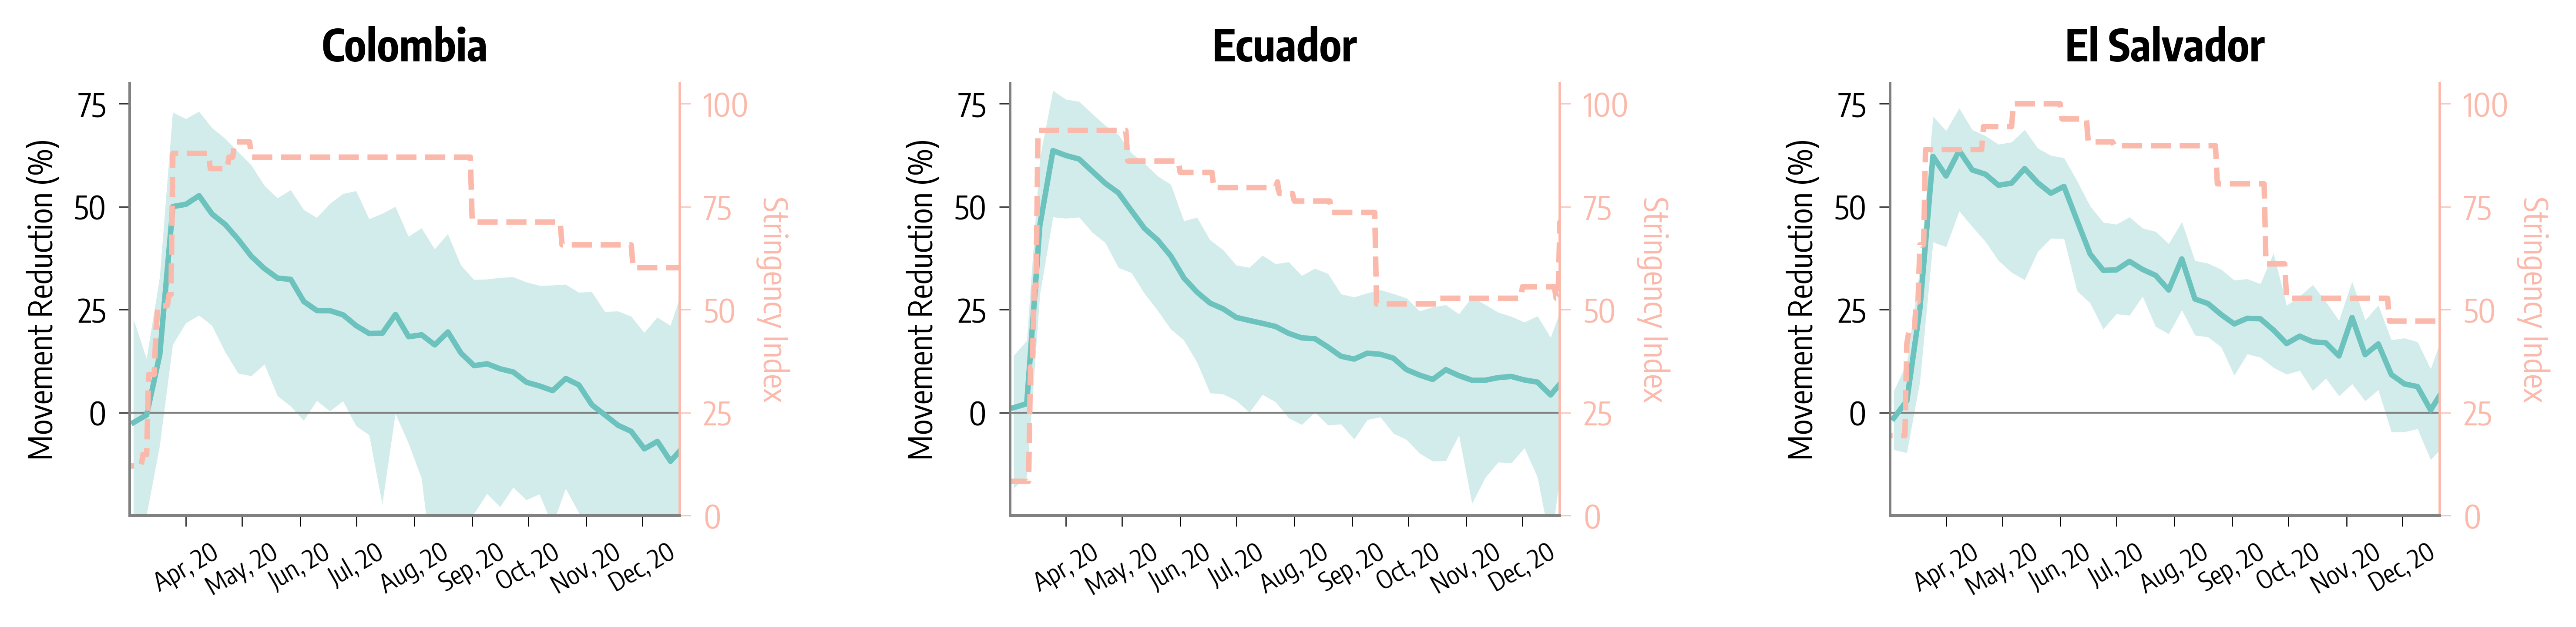

In [3]:
fig, axes = plt.subplots(ncols=3, dpi=600, figsize=(10,2.5))
for i in range(len(countries)):
    plot_movement_metric_minmax(axes[i], countries[i], "all_day_bing_tiles_visited_relative_change", "Movement Reduction (%)", colors[0], -25, 80, legend=False, showstats=True)
    plot_policy(axes[i].twinx(), countries[i], "#FBB9AB", label_xcoord=1.2)

plt.tight_layout()
plt.subplots_adjust(wspace=0.6)
plt.savefig("./img/range_maps_movreduction.pdf", bbox_inches='tight')



colombia - all_day_ratio_single_tile_users
MAX: 47.86726810344828 [22.073799999999995 - 68.43039999999999]
DATE MAX: 2020-04-06 00:00:00


ecuador - all_day_ratio_single_tile_users
MAX: 52.58614512195121 [34.852000000000004 - 68.63699999999999]
DATE MAX: 2020-03-23 00:00:00


el-salvador - all_day_ratio_single_tile_users
MAX: 55.4482741935484 [38.9854 - 65.3584]
DATE MAX: 2020-04-06 00:00:00


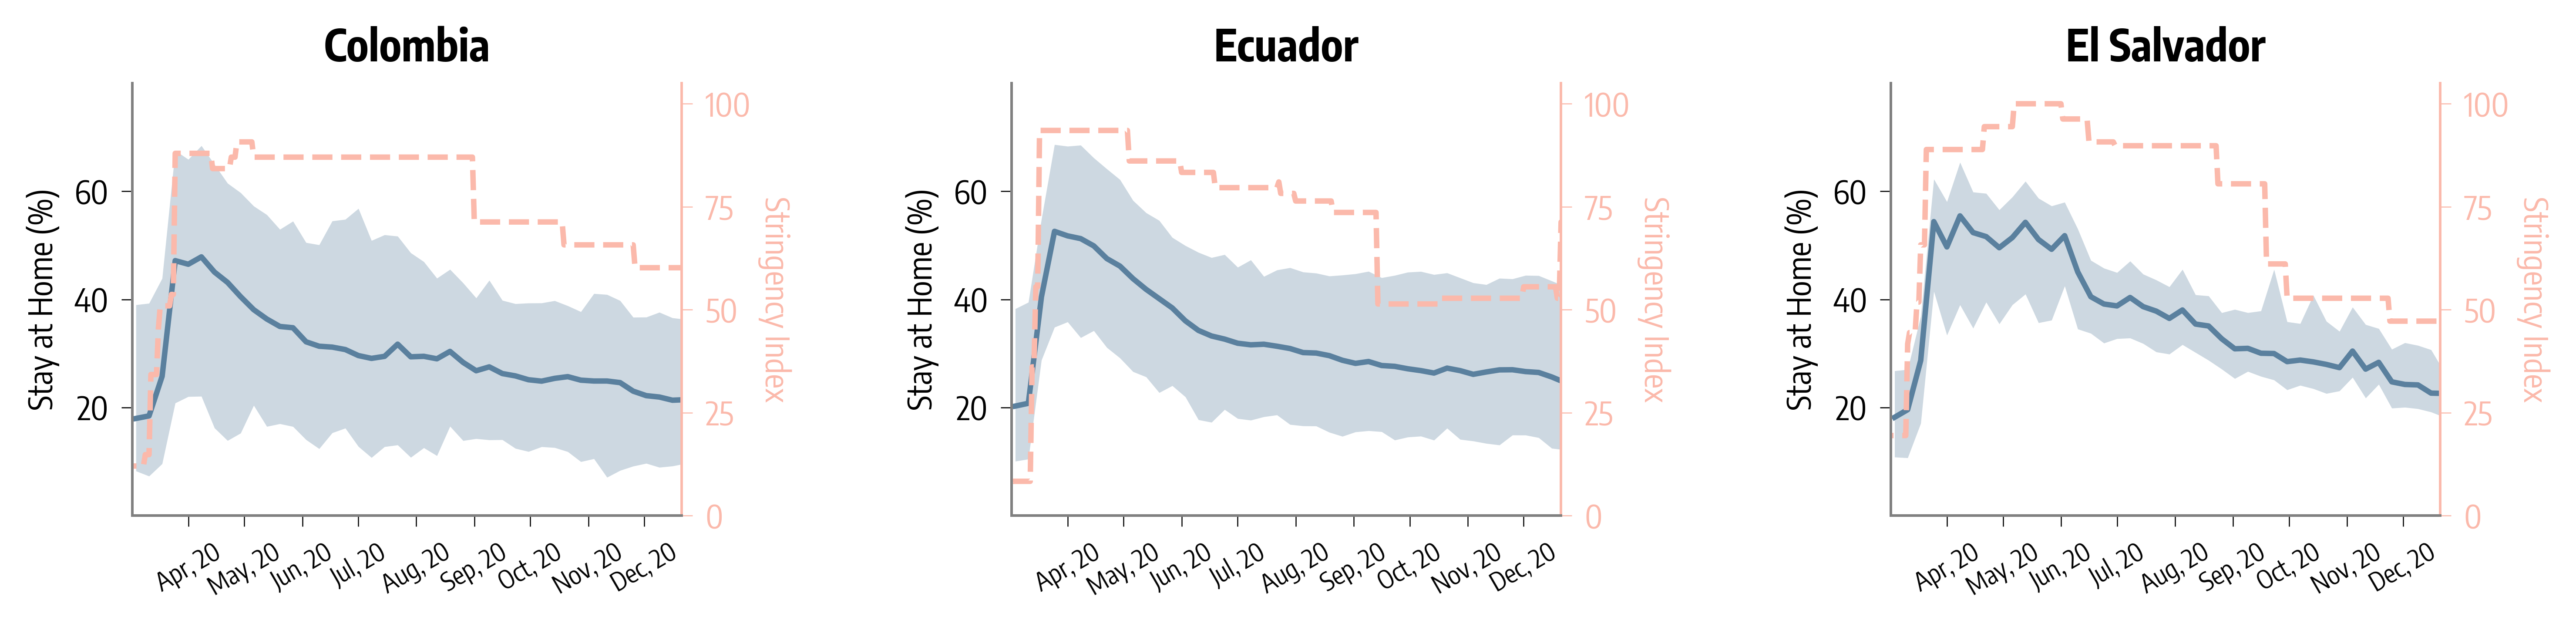

In [4]:
fig, axes = plt.subplots(ncols=3, dpi=600, figsize=(10,2.5))

countries = ["colombia", "ecuador", "el-salvador"]
for i in range(len(countries)):
    plot_movement_metric_minmax(axes[i], countries[i], "all_day_ratio_single_tile_users", "Stay at Home (%)", colors[1], 0, 80, legend=False, showstats=True)
    plot_policy(axes[i].twinx(), countries[i], "#FBB9AB", label_xcoord=1.2)

plt.tight_layout()
plt.subplots_adjust(wspace=0.6)
plt.savefig("./img/range_maps_maxstay.pdf", bbox_inches='tight')

